# 22 - Debiased/Orthogonal Machine Learning
 
다음으로 살펴볼 메타 학습기는 사실 메타 학습기라고 불리기 전부터 있었습니다. 제가 알기론, 인과추론 분야에서 큰 성과를 거둔 2016년 논문에서 나왔습니다. 그 논문은 *Double Machine Learning for Treatment and Causal Parameters*라는 제목으로 많은 분들이 집필에 참여했습니다: Victor Chernozhukov, Denis Chetverikov, Mert Demirer, Esther Duflo (Abhijit Banerjee, Michael Kremer와 함께 세계 빈곤 완화를 위한 실험 방식을 인정받아 2020년 노벨경제학상을 수상함), Christian Hansen, Whitney Newey and James Robins. 이 논문은 너무나 훌륭하기 때문에 저자들을 어벤져스라고 부른 것은 당연합니다 (이 아이디어를 처음 제시한 Paul Goldsmith-Pinkham에게 공을 돌립니다).    

![img](./data/img/debiased-ml/avengers.png)
 
이 논문의 단 하나의 문제점은 읽기에 매우 어렵다는 겁니다 (계량경제학 논문이기 때문에 예상은 되지만). 이 책은 인과추론을 주류로 만드는데 중점이 있기 때문에 우리는 여기서 탈편향/직교 기계학습을 직관적으로 설명하려고 노력할 것 입니다.

하지만 다른 메타 학습기와는 별개로 별도의 챕터로 다뤄야 할 만큼 특별한 이유는 무엇일까요? 제 관심을 끌었던 것은 이 탈편향/직교 ML이 얼마나 정당화되었는가 하는 점이었습니다. 지금까지 살펴본 다른 방법인 T-학습기, S-학습기, X-학습기는 모두 다소 엉성해 보였습니다. 이 방법들이 작동하는 이유에 대해 직관적으로 설명할 수는 있지만, 그다지 일반적이지 않은 것 같았습니다. 반면, 탈편향/직교 머신러닝은 매우 직관적이면서도 매우 엄격하게 적용할 수 있는 일반적인 프레임워크가 있습니다. 또 다른 장점은 탈편향/직교 ML이 연속적이거나 불연속인 처치 환경에서도 모두에서 작동한다는 점인데, 이는 T나 X 학습기가 할 수 없는 일입니다. 이를 설명하는 논문에서 이 추정기의 점근적 분석을 훌륭하게 수행한다는 것은 말할 것도 없습니다. 이제 더 이상 고민할 필요 없이 본론으로 들어가 보겠습니다.  

다시 한 번 동기 부여를 위한 예로 아이스크림 판매 데이터 집합을 사용하겠습니다. 여기서 우리는 가격이 매출에 미치는 영향에 대한 이질성을 찾고자 합니다. 시험 데이터에는 가격이 무작위로 할당되어 있지만 훈련 데이터에는 관찰 가격만 있으므로 편향될 가능성이 있습니다. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast
import statsmodels.formula.api as smf
from matplotlib import style
style.use("ggplot")

ModuleNotFoundError: No module named 'pandas'

In [2]:
test = pd.read_csv("./data/ice_cream_sales_rnd.csv")
train = pd.read_csv("./data/ice_cream_sales.csv")
train.head()

temp  weekday  cost  price  sales
0  17.3        6   1.5    5.6    173
1  25.4        3   0.3    4.9    196
2  23.3        5   1.5    7.6    207
3  26.9        1   0.3    5.3    241
4  20.2        1   1.0    7.2    227

<AxesSubplot:xlabel='price', ylabel='sales'>

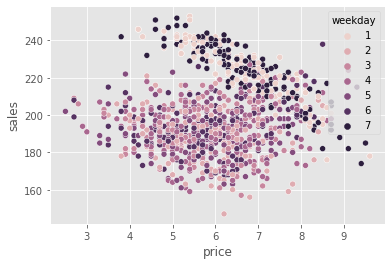

In [3]:
np.random.seed(123)
sns.scatterplot(data=train.sample(1000), x="price", y="sales", hue="weekday")

편향의 한 가지 원인은 매우 명확합니다. 보시다시피 주말(weekdays가 1 그리고 7일 때)에 가격이 훨씬 더 높지만 온도와 비용과 같은 다른 교란 요인도 있을 수 있습니다. 따라서 우리가 이 데이터로 인과 관계를 추론하고 싶다면 이 편향을 조정해야 합니다. 

## 성가신 매개변수를 위한 기계학습
 
이러한 편향을 제거할 수 있는 한 가지 방법은 선형 모델을 사용하여 교란 요인을 통제하면서 가격이 매출에 미치는 처치 효과를 추정하는 것입니다. 
 
$$
Sales_i = \alpha + \tau price_i + \beta_1 temp_i + \beta_2 cost_i + \pmb{\beta_3} Weekday_i + e_i
$$
 
여기서 $\pmb{\beta_3}$는 각 요일 더미와 관련된 매개변수 벡터입니다. 
 
$\tau$가 처치 효과이므로 $\tau$ 매개변수에만 관심이 있다는 점에 유의하세요. 다른 매개변수는 신경 쓰지 않기 때문에 성가신 매개변수라고 부르겠습니다. 하지만 알고 보면 신경 쓰지 않더라도 올바르게 설정하지 않으면 처치 효과가 떨어지기 때문에 올바르게 설정해야 합니다. 그건 좀 성가신 일이죠. 
  
예를 들어 생각해 보면 '온도'와 매출의 관계는 선형적이지 않을 수 있습니다. 우선 기온이 올라가면 더 많은 사람들이 해변에 가서 아이스크림을 사먹을 것이고, 따라서 매출도 늘어날 것입니다. 하지만 어느 순간 너무 더워지면 사람들은 집에 머무르는 것이 최선이라고 결정합니다. 이 시점에서는 매출이 감소할 것 입니다. '온도'와 매출 사이의 관계는 아마도 어딘가에서 정점을 찍고 감소할 것입니다. 즉, 위의 모델은 아마도 잘못된 것입니다. 다음과 같이 이차항이 포함되어야할 것입니다.

$$
Sales_i = \alpha + \tau price_i + \beta_1 temp_i + \beta_2 temp^2_i + \beta_3 cost_i + \pmb{\beta_4} Weekday_i + e_i
$$
 

![img](./data/img/debiased-ml/non-linear.png)

몇 개의 공변량만 있어도 성가신 매개변수를 모델링하는 방법에 대해 생각하는 것은 이미 따분한 일입니다. 하지만 수십, 수백 개의 공변수가 있다면 어떨까요? 최신 데이터에서는 이런 경우가 매우 흔합니다. 그렇다면 어떻게 해야 할까요? 그 해답은 지금까지 도출된 것 중 가장 멋진 계량경제학 정리에 있습니다.

### Frisch-Waugh-Lovell
 
Frisch, Waugh 그리고 Lovell은 선형 회귀의 가장 멋진 점을 발견한 20세기 계량경제학자였습니다. 회귀 잔차와 고정 효과에 대해 이야기할 때 이 정리에 대해 이야기한 적이 있기 때문에 이 정리는 새로운 것이 아닙니다. 하지만 이 정리는 직교 기계학습을 이해하는 데 핵심이므로 다시 한 번 정리할 가치가 있습니다.

특징 집합 $X_1$과 다른 특징 집합 $X_2$가 있는 선형 회귀 모델이 있다고 가정해 보겠습니다. 그런 다음 해당 모델의 매개 변수를 추정합니다.
 
$
\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2
$
  
여기서 $X_1$ 및 $X_2$ 는 특징 행렬(특징당 하나의 열과 관측치당 하나의 행)이고 $\hat{\beta_1}$ 과 $\hat{\beta_2}$ 는 행 벡터입니다. 다음 단계를 진행하면 정확히 동일한 $\hat{\beta_1}$ 매개 변수를 얻을 수 있습니다.

1. 두 번째 특징 집합으로 출력값 $y$에 회귀모형을 적합합니다. $\hat{y^*} = \hat{\gamma_1} X_2$.
2. 두 번째 특징 집합으로 첫 번째 특징 집합에 회귀모형을 적합합니다. $\hat{X_1} = \hat{\gamma_2} X_2$.
3. 잔차를 얻습니다. $\tilde{X}_1 = X_1 - \hat{X_1}$ 과 $\tilde{y}_1 = y - \hat{y^*}$.
4. 특징값의 잔차로 출력값의 잔차에 회귀모형을 적합합니다. $\tilde{y} = \hat{\beta_1} \tilde{X}_1$.
 
이것은 정말 멋집니다. 여기에는 일반적인 표현이 있지만 하나의 특징 집합이 처치 변수일 수 있다는 것에 주목하세요. 즉, 모든 성가신 매개 변수를 개별적으로 추정할 수 있습니다. 먼저 특징을 가지고 출력값에 대해 회귀모형을 적합하여 출력값 잔차를 구합니다. 그런 다음 특징을 가지고 처치 변수에 대한 회귀모형을 적합하여 처치 변수에 대한 잔차를 얻습니다. 마지막으로, 출력값 잔차에 대해서 특징 잔차를 가지고 회귀모형을 적합합니다. 이렇게 하면 특징과 처치를 가지고 동시에 출력값에 대해서 회귀모형을 적합한 추정치와 정확하게 동일한 추정치를 얻을 수 있습니다.

하지만 제 말만 믿지 마세요. FWL은 인과 관계 추론에 관심이 있는 사람이라면 누구나 한 번쯤은 해봐야 하는 작업입니다. 아래 예에서는 먼저 출력값(매출)와 처치(가격)에 대한 공변량의 효과를 추정하여 처치 효과를 추정합니다.

In [4]:
my = smf.ols("sales~temp+C(weekday)+cost", data=train).fit()
mt = smf.ols("price~temp+C(weekday)+cost", data=train).fit()

그런 다음 잔차를 가지고 판매 가격의 ATE를 추정합니다.

In [5]:
smf.ols("sales_res~price_res", 
        data=train.assign(sales_res=my.resid, # sales residuals
                          price_res=mt.resid) # price residuals
       ).fit().summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

ATE를 -4로 추정했는데, 이는 가격이 1단위 인상될 때마다 판매량이 4단위 감소한다는 것을 의미합니다.

이제 동일한 매개 변수를 추정해 보겠습니다. 하지만 이번에는 동일한 모델에 처치와 공변량을 포함하겠습니다.

In [6]:
smf.ols("sales~price+temp+C(weekday)+cost", data=train).fit().params["price"]

-4.000429145475403

보시다시피 정확히 같은 숫자입니다! 이는 처치 효과를 한 번에 추정하는 것과 FWL 단계에서 분리하는 것이 수학적으로 동일하다는 것을 보여줍니다.

이를 다른 방식으로 표현하면, 처치 효과는 **잔차에 대한 회귀**에서 도출할 수 있는데, $Y$를 $X$에 대해서 회귀모형을 적합하여 구한 잔차에 대해서 이를 $T$를 $X$에 대해서 회귀모형 적합하여 얻은 잔차를 가지고 회귀모형을 적합한 것입니다. 회귀 연산자를 $\sim$이라고 가정하면 FWL 정리를 다음과 같이 요약할 수 있습니다.

$
(Y - (Y \sim X)) \sim (T - (T \sim X))
$
 
이는 본질적으로 다음 모델에서 인과 매개변수 $\tau$ 를 추정하는 것입니다.
 
$
Y_i - E[Y_i | X_i]
= \tau \cdot (T_i - E[T_i | X_i]) + \epsilon
$
 
앞서 말했듯이, FWL은 인과 매개변수의 추정 절차와 성가신 매개변수의 추정 절차를 분리할 수 있다는 점에서 매우 훌륭합니다. 하지만 여전히 첫 번째 질문, 즉 어떻게 하면 성가신 매개변수에 올바른 함수 형태를 지정해야 하는 모든 번거로움을 피할 수 있을까요? 다시 말해, 어떻게 하면 성가신 매개변수에 대해 걱정할 필요 없이 인과 매개변수에만 집중할 수 있을까요? 바로 여기에 기계학습이 등장합니다.

![img](./data/img/debiased-ml/drown-ols.png)

### 더한 Frisch-Waugh-Lovell 


이중/탈편향 기계학습은 Frisch, Waugh 그리고 Lovell 정리에 좀 더 추가한 정도입니다. 출력값과 및 처치 잔여값을 구성할 때 기계학습 모델을 사용한다는 개념은 매우 간단합니다: 

$
Y_i - \hat{M}_y(X_i)
= \tau \cdot (T_i - \hat{M}_t(X_i)) + \epsilon
$
 
여기서 $\hat{M}_y(X_i)$ 는 $E[Y|X]$ 을 추정하고 $\hat{M}_t(X_i)$ 은 $E[T|X]$ 을 추정합니다.
  
기계학습 모델은 매우 유연하기 때문에 $Y$와 $T$의 잔차를 추정할 때 교호작용과 비선형성을 모델링할 수 있고 동시에 FWL 스타일의 직교화를 유지할 수 있다는 것입니다. 즉, 올바른 처치 효과를 얻기 위해 공변량 $X$와 출력값 $Y$ 간의 관계 또는 공변량과 처치 간의 관계에 대한 매개변수 가정을 할 필요가 없습니다. 관찰되지 않은 교란변수가 없다면 다음과 같은 직교화 절차를 통해 ATE를 복구할 수 있습니다:

1. 유연한 기계학습 모델 $M_y$을 통해 $X$를 가지고 출력값 $Y$를 추정하세요. 
2. 유연한 기계학습 모델 $M_y$을 통해 $X$를 가지고 처치 $T$를 추정하세요. 
3. 잔차를 구하세요. $\tilde{Y} = Y - M_y(X)$ 과 $\tilde{T} = T - M_t(X)$.
4. 처치 잔차를 가지고 출력값 잔차에 대한 회귀모형을 적합하세요. $\tilde{Y} = \alpha + \tau \tilde{T}$.
 
여기서 $\tau$ 는 인과 매개변수 ATE이며, 예를 들어 OLS로 추정할 수 있습니다. 

기계학습을 통해 얻을 수 있는 힘은 유연성입니다. 기계학습은 매우 강력하기 때문에 성가신 매개변수의 관계에서 복잡한 함수 형태를 포착할 수 있습니다. 하지만 이러한 유연성은 과적합의 가능성을 고려해야 한다는 것을 의미하기 때문에 문제가 되기도 합니다.
 
![img](./data/img/debiased-ml/ml-problem.png)
 
Chernozhukov et al (2016) 에서 과적합이 얼마나 문제가 될 수 있는지에 대해 훨씬 더 심도 있고 엄격하게 설명되어 있으니 꼭 읽어보시길 권합니다. 하지만 여기서는 좀 더 직관에 기반한 설명을 이어가겠습니다. 
 
문제를 확인하려면 $M_y$ 모델이 과적합이라고 가정해 보겠습니다. 그 출력값 잔차 $\tilde{Y}$가 실제보다 작아질 것입니다. 이는 또한 $M_y$가 $X$와 $Y$ 사이의 관계만 포착하는 것이 아니라 그 이상의 것을 포착하고 있다는 것을 의미합니다. 그 이상의 것 중 일부는 $T$와 $Y$ 사이의 관계이며, $M_y$가 그 중 일부를 포착하고 있다면 잔차 회귀는 0을 향해 편향될 것입니다. 다시 말해, $M_y$는 인과 관계를 포착하고 최종 잔차 회귀모형에 맡기지 않습니다. 
 
이제 $M_t$ 과적합의 문제점을 보려면 $T$의 분산을 예상보다 더 많이 설명한다는 것을 알 수 있습니다. 결과적으로 처치 잔차는 예상보다 작은 분산을 갖게 됩니다. 처치의 분산이 작으면 최종 추정치의 분산이 커집니다. 마치 거의 모든 사람의 처치가 동일한 것과 같습니다. 그리고 모든 사람이 동일한 처치를 받는다면, 다른 처치 수준에서 어떤 일이 일어날지 추정하기가 매우 어려워집니다. 참고로, $T$가 $X$의 결정론적 함수인 경우, 즉 positivity 가정이 위반되는 경우에도 이런 일이 발생합니다.

기계학습 모델을 사용할 때 이러한 문제가 발생하는데, 이를 어떻게 해결할 수 있을까요? 그 해답은 교차 예측과 out-of-fold 잔차라고 부르는 것에 있습니다.
 
![img](./data/img/debiased-ml/cross-prediction.png)
 
데이터를 동일한 크기의 K 부분으로 분할합니다. 그런 다음 각 부분 k에 대해 다른 모든 K-1 샘플에 대해 기계학습 모델을 추정하고 k 부분에 대한 잔차를 만듭니다. 이러한 잔차는 out-of-fold 예측을 사용하여 만들어진다는 것에 주목하세요. 데이터의 한 부분에 모델을 적합하되, 다른 부분에 대한 예측과 잔차를 만듭니다. 

따라서 모델이 과적합하더라도 잔차를 인위적으로 0으로 만들지 않습니다. 마지막으로, 모든 K 부분에 대한 예측을 결합하여 최종 인과 모델 $\tilde{Y} = \alpha + \tau \tilde{T}$를 추정합니다.

지금까지 많은 내용을 다루었지만 예제 없이는 따라가기 어려울 수 있습니다. 이 모든 이론과 함께 이중/탈편향 기계학습을 단계별로 구현해 보겠습니다. 이 과정에서 각 단계가 무엇을 하는지 설명할 기회를 갖도록 하겠습니다. 

먼저 기계학습 모델을 사용하여 성가신 관계를 추정해 보겠습니다. 처치 모델 $M_t$부터 시작하겠습니다. 공변량인 `temp`, `weekday`, `cost`로부터 가격을 예측하기 위해 LGBM 모델을 사용하겠습니다. 이러한 예측은 교차 예측이 될 것이며, 이는 `sklearn`의 `cross_val_predict` 함수를 사용하여 얻을 수 있습니다. 또한 시각화를 위해 평균 $\hat{\mu_t}$를 잔차에 추가할 것입니다.

In [7]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res =  train[T] -
                          cross_val_predict(debias_m, train[X], train[T], cv=5)
                          + train[T].mean()) # add mu_t for visualization. 

$M_t$ 모델을 탈편향 모델이라고 부르는 것을 주목하세요. 이는 이 모델이 이중/탈편향 기계학습에서 수행하는 역할이 처치의 탈편향 중 하나이기 때문입니다. 잔차 $\tilde{T} = T - M_t(X)$는 $X$의 모든 교란 편향이 모델에 의해 제거된 처치의 버전으로 볼 수 있습니다. 즉, $\tilde{T}$는 $X$에 직교합니다. 직관적으로 $\tilde{T}$는 더 이상 $X$로 설명할 수 없는데, 이는 이미 설명이 됐기 때문입니다. 

이를 확인하기 위해 앞에서 본 것과 동일한 플롯을 가격을 가격 잔차로 바꾸어 그려볼 수 있습니다. 이전에는 주말의 가격이 더 높았던 것을 기억하시나요? 이제 그런 편향이 사라졌습니다. 모든 요일의 가격 잔차 분포가 동일합니다.

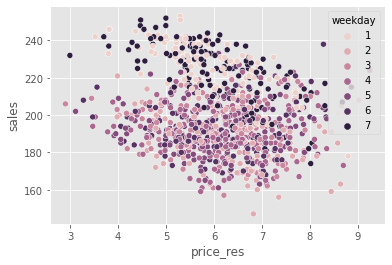

In [8]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales", hue="weekday");

$M_t$의 역할은 처치의 편향을 없애는 것이지만, $M_y$는 어떨까요? 그 역할은 $Y$에서 분산을 제거하는 것입니다. 따라서 이를 노이즈 제거 모델이라고 부르겠습니다. 직관적으로 $M_y$는 $X$로 인한 모든 분산이 설명된 출력값의 버전을 생성합니다. 그 결과, $\tilde{Y}$에서 인과 관계 추정이 더 쉬워집니다. 노이즈가 적기 때문에 인과 관계를 더 쉽게 확인할 수 있습니다. 

In [9]:
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train_pred.assign(sales_res =  train[y] -
                               cross_val_predict(denoise_m, train[X], train[y], cv=5)
                               + train[y].mean())

이전과 동일한 그래프를 그릴 때, 매출을 매출 잔차로 바꾸면 $Y$의 분산이 이전보다 훨씬 작아진 것을 볼 수 있습니다. 

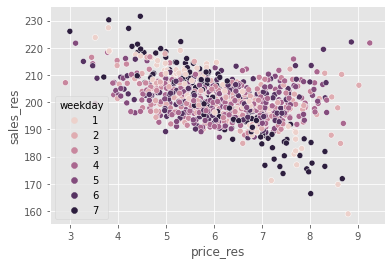

In [10]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales_res", hue="weekday");

이제 가격과 매출 간의 음의 관계를 쉽게 확인할 수 있습니다. 

마지막으로 인과 관계를 추정하기 위해 잔차에 대한 회귀 분석을 수행할 수 있습니다.

In [11]:
final_model = smf.ols(formula='sales_res ~ price_res', data=train_pred).fit()
final_model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

보시다시피, 판매량과 가격의 잔차화된 또는 직교 버전을 사용하면 가격과 판매량 간의 관계가 음의 관계라는 것을 매우 확신할 수 있습니다. 가격을 인상하면 아이스크림에 대한 수요는 감소해야 합니다.
 
그러나 가격과 판매 사이의 비잔차화된 관계 또는 원래 관계를 살펴보면 편향으로 인해 양(+)의 관계를 발견할 수 있습니다. 이는 높은 매출을 예상하여 가격을 인상하기 때문입니다.

In [12]:
final_model = smf.ols(formula='sales ~ price', data=train_pred).fit()
final_model.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

### 이중 기계학습을 이용한 CATE 추정
 
지금까지 이중/탈편향 기계학습을 사용하면 평균처치효과(ATE)를 추정할 수 있는지 봤지만, 처치효과 이질성 또는 조건부 평균처치효과(CATE)를 추정하는 데도 사용할 수 있습니다. 이제, 기본적으로 인과 매개변수 $\tau$는 공변량에 단위에 따라 달라진다고 말할 수 있습니다. 

$
Y_i - {M}_y(X_i)
= \tau(X_i) \cdot (T_i - {M}_t(X_i)) + \epsilon_i
$
 
이 모델을 추정하기 위해 가격 및 매출의 동일한 잔차화된 버전을 사용하지만, 이제 가격 잔차를 다른 공변량과 상호작용이 존재하도록 할 것입니다. 그러면 선형 CATE 모델을 적합할 수 있습니다.

$
\tilde{Y_i} = \alpha + \beta_1 \tilde{T_i} + \pmb{\beta}_2 \pmb{X_i} \tilde{T_i} + \epsilon_i
$
 
이러한 모델을 추정하고 나면, CATE를 예측하기 위해서 무작위 시험 데이터를 사용할 것입니다. 이 최종 모델은 선형 모델이기 때문에 기계적으로 CATE를 계산할 수 있습니다:

$
\hat{\mu}(\partial Sales_i, X_i) = M(Price=1, X_i) - M(Price=0, X_i)
$

여기서 $M$는 우리의 최종 선형 모델입니다.

In [13]:
final_model_cate = smf.ols(formula='sales_res ~ price_res * (temp + C(weekday) + cost)', data=train_pred).fit()

cate_test = test.assign(cate=final_model_cate.predict(test.assign(price_res=1))
                        - final_model_cate.predict(test.assign(price_res=0)))

이 모델이 가격 민감도가 높은 단위와 가격 민감도가 낮은 단위를 구분하는 데 얼마나 좋은지 확인하기 위해 누적 탄력성 곡선을 사용하겠습니다. 

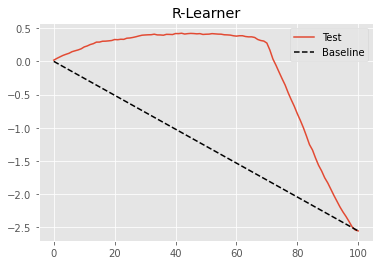

In [14]:
gain_curve_test = cumulative_gain(cate_test, "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

위의 곡선에서 볼 수 있듯이 최종 선형 모델을 사용한 이중/탈편향 기계학습 절차는 이미 매우 우수합니다. 하지만 더 잘할 수 있을지도 모릅니다. 사실 이 절차는 메타 학습자처럼 이해할 수 있는 매우 일반적인 절차입니다. Nie와 Wager는 Robinson(1988)의 연구를 인정하고 잔차화의 역할을 강조하기 위해 이를 R-Learner라고 불렀습니다.
 
이러한 일반화는 이중/탈편향 기계학습 절차가 우리가 원하면서 최소화하고자 하는 새로운 손실 함수를 정의한다는 사실을 깨닫는 데서 비롯됩니다. 다음으로 목표 변환 방법 또는 F-학습자에 대해 논의할 때 이전에 보았던 것과 매우 유사한 방식으로 이를 수행하는 방법을 살펴보겠습니다. 


## 비모수 이중/탈편향 기계학습
 
이중 기계학습의 장점은 인과 모델에서 성가신 매개변수를 학습하는 번거로움에서 벗어날 수 있다는 것입니다. 이를 통해 ATE든 CATE든 관심 있는 인과 매개변수를 학습하는 데 집중할 수 있습니다. 그러나 위의 설명에서는 여전히 기계학습 잔차화 후 선형 모델을 최종 인과 모델로 사용하고 있었습니다. 이 예에서는 가격이 매출에 선형적으로 영향을 미친다고 가정하고 있다는 뜻입니다. 작은 가격 범위에서는 괜찮을지 모르지만, 미시경제학 이론에 따르면 반드시 그렇지는 않습니다. 낮은 가격에서는 가격이 1단위 상승하면 수요가 2단위 감소할 수 있습니다. 하지만 가격이 높아지면 가격이 1단위 상승해도 수요는 1단위만 감소할 수 있습니다. 이는 선형적인 관계가 아닙니다.

여기서 미시경제학 이론을 활용하여 처치에 대한 출력값의 함수 형태를 추측할 수도 있지만, 기계학습 모델에 이를 맡길 수도 있습니다. 즉, 기계가 복잡한 함수 형태를 학습하도록 하는 것입니다. 원래의 이중/탈편향 기계학습 알고리즘에 몇 가지 변화를 주면 충분히 가능합니다.
 
먼저, 이전과 똑같이 시작하여 기계학습 모델의 교차 예측을 통해 치료와 결과를 직교화합니다.

In [15]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res =  train[T] - cross_val_predict(debias_m, train[X], train[T], cv=5),
                          sales_res =  train[y] - cross_val_predict(denoise_m, train[X], train[y], cv=5))

지금까지는 달라진 것이 없습니다. 이제부터 흥미로운 점이 있습니다. 이중/탈편향 기계학습 모델은 다음과 같이 데이터를 모델링합니다.
 
$
Y_i = \hat{M}_y(X_i) + \tau(X_i) \big(T_i - \hat{M}_t(X)\big) + \hat{\epsilon}_i
$

여기서 $\hat{M}_y$ 및 $\hat{M}_t$는 각각 특징으로부터 출력값과 처치를 예측하는 모델입니다. 위의 항을 재배열하면 오차 항을 분리할 수 있습니다.

$
\hat{\epsilon}_i = \big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)
$

이제 이것을 **인과적 손실 함수**라고 부를 수 있기 때문에 이것은 정말 멋진 일입니다. 즉, 이 손실의 제곱을 최소화하면 $\tau(X_i)$의 기대값을 추정할 수 있으며, 이것이 바로 CATE입니다.

$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg(\big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)\bigg)^2
$
 
이 손실은 R-학습기가 최소화하는 손실이기 때문에 **R-손실**이라고도 합니다. 그렇다면 이 손실 함수를 어떻게 최소화할 수 있을까요? 사실 여러 가지 방법이 있지만 여기서는 가장 간단한 방법을 다루겠습니다. 먼저, 기술적인 표기법을 깔끔하게 정리하기 위해 이전에 사용했던 손실 함수를 다시 작성하되, 처치와 결과값의 잔차화된 버전을 사용해 보겠습니다. 

$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg( \tilde{Y}_i - \tau(X_i) \tilde{T}_i \bigg)^2
$
 
마지막으로 algebraic parkour를 통해 괄호에서 $\tilde{T}_i$를 빼고 손실 함수의 제곱 부분에서 $\tau(X_i)$를 분리할 수 있습니다.

$$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1} \tilde{T}_i^2 \left(\frac{\tilde{Y}_i}{\tilde{T}_i} - \tau(X_i)\right)^2 
$$
 
위의 손실을 최소화하는 것은 괄호 안에 있는 것을 최소화하는 것과 같지만, 각 항에 $\tilde{T}_i^2$만큼 가중치가 있습니다. 괄호 안의 값을 최소화하는 것은 $\frac{\tilde{Y}_i}{\tilde{T}_i}$를 예측하는 것과 동일합니다. 이를 비모수적 인과 관계 손실을 얻기 위한 가중치 트릭이라고 합니다. 이것이 앞서 살펴본 목표 변환 아이디어와 얼마나 유사한지 주목하세요. 이것은 실제로 목표 변환이지만 가중치 트릭이 추가되었습니다.
 
코드에 들어가기 전에 요약하자면, 이제 성가신 모델과 처치 및 결과값의 잔차화된 버전이 있으므로 다음과 같이 하겠습니다.
1. 가중치 $\tilde{T}_i^2$를 생성합니다.
2. 목표 $\dfrac{\tilde{Y}_i}{\tilde{T}_i}$를 생성합니다.
3. 가중치(1)를 사용하면서 어떤 예측 방법을 사용하여 목표(2)를 예측합니다. 
 
다음은 코드입니다. 보시다시피 매우 간단합니다.

In [16]:
model_final = LGBMRegressor(max_depth=3)
 
# create the weights
w = train_pred["price_res"] ** 2 
 
# create the transformed target
y_star = (train_pred["sales_res"] / train_pred["price_res"])
 
# use a weighted regression ML model to predict the target with the weights.
model_final.fit(X=train[X], y=y_star, sample_weight=w);

위의 기계학습 모델은 기존의 예측 모델임에도 불구하고 CATE를 추정하고 있습니다. 이것이 바로 비모수적 이중 기계학습의 힘입니다. 이전에는 CATE 추정을 위한 최종 모델로 선형 회귀를 사용했습니다. 이제 일반 손실을 정의했으므로 원하는 예측 모델을 최종 모델로 사용할 수 있습니다. 
 
이제 테스트 데이터셋을 사용하여 이 비모수적 버전을 이전에 사용한 선형 버전과 비교해 보겠습니다. 
 
먼저 개별 처치 효과를 추정합니다.

In [17]:
cate_test_non_param = test.assign(cate=model_final.predict(test[X]))

다음으로, 비모수 누적 탄성 곡선을 모수(선형) 버전의 이중/직교 기계학습에서 얻은 곡선과 나란히 플롯을 그릴 수 있습니다.

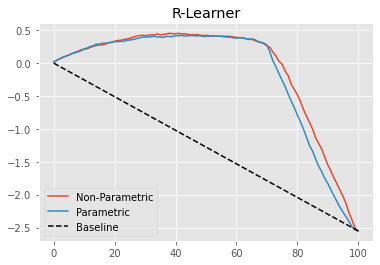

In [18]:
gain_curve_test_non_param = cumulative_gain(cate_test_non_param, "cate", y=y, t=T)
plt.plot(gain_curve_test_non_param, color="C0", label="Non-Parametric")
plt.plot(gain_curve_test, color="C1", label="Parametric")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

여기서 큰 개선은 아니지만 뭔가 있습니다. 또한 처치 함수의 함수 형태를 지정할 필요가 없다는 것은 이미 큰 이점입니다. 

### 비모수적이란 것은 무엇인가요?

계속 진행하기 전에 흔히 오해하는 한 가지를 짚고 넘어가고자 합니다. 비모수적 이중 기계학습 모델을 사용하여 CATE를 추정하면 비선형 치료 효과를 얻을 수 있을 것처럼 보입니다. 예를 들어, 할인 매출에 비선형적으로 영향을 미치지만 제곱근 함수를 통해 영향을 미치는 매우 간단한 데이터 생성 과정(DGP)를 가정해 보겠습니다. 

$
Sales_i = 20 + 10*\sqrt{Discount_i} + e_i
$
  
처치 효과는 Sales 함수의 처치에 대한 도함수로 주어집니다.

$
\dfrac{\partial Sales_i}{\partial Discount_i} = \dfrac{10}{2\sqrt{Discount_i}}
$
 
보시다시피 처치 효과는 **선형적이지 않습니다**. 치치 효과가 증가함에 따라 실제로 약해집니다. 이는 이 데이터 생성 과정에 대해 많은 의미가 있습니다. 처음에는 약간의 할인이 매출을 크게 증가시킵니다. 하지만 너무 많은 할인을 제공하면 사람들이 무한정 구매를 원하지 않기 때문에 할인 단위가 늘어날수록 매출에 미치는 영향은 점점 줄어들게 됩니다. 따라서 할인은 고객이 만족할 때까지만 효과가 있습니다. 

그렇다면 비모수적 기계학습이 이러한 처치 효과가 최고인 정도를 포착할 수 있을까요? 작은 할인 수준에서 할인이 더 높으면 치치 효과가 더 낮을 것이라고 추론할 수 있을까요? 정답은... 어느 정도입니다. 이를 더 잘 이해하기 위해 위의 데이터 생성 과정과 같은 데이터를 생성해 보겠습니다.

In [19]:
np.random.seed(321)
n=5000
discount = np.random.gamma(2,10, n).reshape(-1,1)
discount.sort(axis=0) # for better ploting
sales = np.random.normal(20+10*np.sqrt(discount), 1)

이 DGP를 플롯으로 그리면 이러한 변수 간의 제곱근 관계를 확인할 수 있습니다.

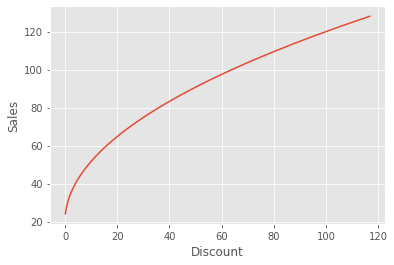

In [20]:
plt.plot(discount, 20 + 10*np.sqrt(discount))
plt.ylabel("Sales")
plt.xlabel("Discount");


이제 이 데이터에 비모수적 이중/탈편향 기계학습 모델을 적용해 보겠습니다. 

In [21]:
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

# orthogonalising step
discount_res =  discount.ravel() - cross_val_predict(debias_m, np.ones(discount.shape), discount.ravel(), cv=5)
sales_res =  sales.ravel() - cross_val_predict(denoise_m, np.ones(sales.shape), sales.ravel(), cv=5)

# final, non parametric causal model
non_param = LGBMRegressor(max_depth=3)
w = discount_res ** 2 
y_star = sales_res / discount_res

non_param.fit(X=discount_res.reshape(-1,1), y=y_star.ravel(), sample_weight=w.ravel());

위의 모델을 사용하면 CATE 추정치를 얻을 수 있습니다. 여기서 문제는 CATE가 선형적이지 않다는 것입니다. 처치가 증가함에 따라 CATE는 감소해야 합니다. 우리가 답하고자 하는 질문은 비모수적 모델이 이러한 비선형성을 포착할 수 있는지 여부입니다. 


이 질문에 제대로 답하기 위해 이중/탈편향 기계학습이 데이터 생성 과정에 대한 기본 가정이 무엇인지 기억해 봅시다. 이러한 가정은 앞서 설명한 방정식에서 확인할 수 있습니다.
 
$
\tilde{Y}_i = \tau(X_i) \tilde{T}_i + e_i
$
 
즉, 잔차화된 결과는 잔차화된 처치에 조건부 처치 효과를 곱한 값과 같다는 것을 말합니다. 이는 **처치가 결과에 선형적으로 영향을 미친다는 것을 의미합니다**. 여기에는 비선형성이 없습니다. 위의 모델은 치료를 1에서 10으로 또는 100에서 110으로 늘리면 결과가 고정된 양 $\tau(X_i)$만큼 증가한다고 말합니다. 단순한 곱셈입니다. 

그렇다면 비모수적 모델로는 처치 효과의 비선형성을 포착할 수 없다는 뜻일까요? 다시 말하지만, 그렇지 않습니다. 오히려 이중 기계학습 모델은 **비선형 CATE에 대한 국소 선형 근사치를 찾습니다**. 즉, 해당 처치 수준 또는 처치 주변에서 처치와 관련된 결과의 도함수를 구합니다. 이는 처치값에서 결과값 함수에 접하는 직선의 기울기를 구하는 것과 같습니다.

![img](./data/img/debiased-ml/linear-aprox.png)
 
즉, 비모수적 이중 기계학습은 처치를 늘릴수록 처치 효과가 작아진다는 것을 알아낼 것입니다. 하지만 비선형 처치 효과가 아니라 국소적인 선형 처치 효과만 구하게 됩니다. 이러한 선형 근사치를 실제 비선형 인과 효과와 비교하여 플롯을 그릴 수도 있으며, 실제로 좋은 근사치입니다. 

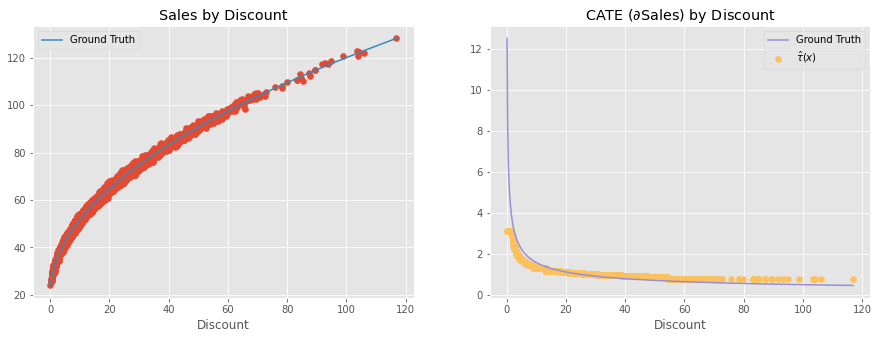

In [22]:
cate = non_param.predict(X=discount)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(discount, sales)
plt.plot(discount, 20 + 10*np.sqrt(discount), label="Ground Truth", c="C1")
plt.title("Sales by Discount")
plt.xlabel("Discount")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(discount, cate, label="$\hat{\\tau}(x)$", c="C4")
plt.plot(discount, 5/np.sqrt(discount), label="Ground Truth", c="C2")
plt.title("CATE ($\partial$Sales) by Discount")
plt.xlabel("Discount")
plt.legend();

이것은 기술적인 문제처럼 들릴 수 있지만 매우 실용적인 결과를 가져옵니다. 예를 들어, 위의 예에서 고객에 대한 처치 효과가 2라고 가정하면, 할인을 1 단위로 늘리면 해당 고객에 대한 판매량이 2 단위로 증가합니다. 이를 보고 다음과 같이 생각할 수 있습니다. 할인을 많이 해야겠어!"라고 생각할 수 있습니다. 결국, 1 단위 할인할 때마다 2개를 판매할 수 있겠지"라고 생각할 수 있습니다. 그러나 이는 잘못된 결론입니다. 처치 효과는 해당 할인 수준에서만 2입니다. 할인을 늘리는 즉시 효과가 떨어집니다. 예를 들어, 이 가상의 고객이 할인을 5만 받았기 때문에 처치 효과가 매우 높다고 가정해 보겠습니다. 그 엄청난 처치 효과를 보고 그 고객에게 20달러를 할인하는 것을 정당화하기 위해 할인을 늘린다고 가정해 보겠습니다. 하지만 그렇게 하면 효과가 2에서 0.5 정도로 줄어들 수 있습니다. 처치 효과가 2일 때는 의미가 있었던 20 할인이 처치 효과가 0.5일 때는 더 이상 수익성이 없을 수도 있습니다.

즉, 비선형 처치 효과를 새로운 처치 수준으로 외삽할 때는 각별히 주의해야 합니다. 그렇지 않으면 수익성이 매우 낮은 결정을 내릴 수 있습니다. 다른 말로 표현하자면, 처치 효과가 선형적이지 않은 경우, 비모수적 이중/탈편향 기계학습조차도 **반사실적 예측을 위해 고군분투한다는 것입니다**. 낮은 처치 수준에서 높은 처치 수준으로 또는 그 반대로 처치 효과(TE)를 선형적으로 추정하려고 시도합니다. 그리고 비선형성으로 인해 이러한 외삽은 실패할 가능성이 높습니다. 
 
이 문제를 해결하기 위한 마지막 아이디어가 있습니다. 이 아이디어는 이전에 보았던 것보다 훨씬 덜 과학적이라는 점을 명심하세요. 직교화 절차를 적용한 후 S-학습기를 사용하는 것으로 요약되지만, 제가 너무 앞서 나가고 있습니다. 다음에 살펴보겠습니다. 

![img](./data/img/debiased-ml/non-sci.png)

## 비과학적 이중/탈편향 기계학습

마지막으로 시도할 아이디어는 사고방식의 근본적인 전환입니다. 더 이상 CATE에 대한 선형 근사치를 추정하려고 하지 않을 것입니다. 대신 반사실 예측을 할 것입니다.

![img](./data/img/debiased-ml/cf-pred.png)

CATE는 데이터 포인트에서 결과값 함수의 기울기입니다. 처치를 아주 조금 늘렸을 때 결과가 얼마나 변화할 것으로 예상하는지를 나타냅니다. 좀 더 기술적으로 말하면 해당 지점의 미분계수입니다. 반면에 반사실 예측은 단일 데이터 포인트에서 전체 결과 곡선을 다시 생성하려는 시도입니다. 현재 처치가 아닌 다른 수준의 처치가 이루어졌을 때 어떤 결과가 나올지 예측하는 것, 그래서 반사실 예측입니다. 
 
그렇게 할 수 있다면 한 개체에 다양한 처치를 시뮬레이션하고 각기 다른 처치 수준에서 개체가 어떻게 반응할지 예측할 수 있습니다. 이는 단일 포인트에서 전체 곡선을 추정하는 것이기 때문에 매우 위험한 작업입니다. 또한 이 방법을 실제로 많이 사용해 보았지만, 이 방법이 어떻게, 왜 작동하는지에 대한 과학적 논문은 아직 찾지 못했습니다. 그래서 저는 이 기법을 비과학적 이중 기계학습이라고 부릅니다. 간단히 말해, 조심하세요!
 
이 방법은 다음과 같습니다. 먼저, 처치와 결과값의 잔차화된 버전이 있는 기존의 이중/탈편향-기계학습 식으로부터 시작하겠습니다.

$
\tilde{Y}_i = \tau(X_i) \tilde{T}_i + e_i
$
 
이제 처치를 처치 효과 함수 내부로 옮기겠습니다. 이렇게 하면 처치 효과가 비선형적, 즉 처치 자체에 따라 처치 효과가 변경될 수 있습니다.

$
\tilde{Y}_i = \tau(X_i, \tilde{T}_i)  + e_i
$

이 처치가 어떻게 작동하는지 모르기 때문에 이것은 위험한 작업입니다. 우리가 아는 것은 이상한 비선형 함수일 수 있다는 것입니다. 하지만 다행히도 우리는 기계학습으로 이상한 함수를 추정하는 방법을 알고 있습니다. 그래서 그렇게 할 것입니다. 간단히 말해서, 잔차화된 처치 $\tilde{T}$에서 잔존화된 결과 $\tilde{Y}$를 예측하기 위해 특징 $X$와 함께 기계학습 모델을 적합할 것입니다. 잔차화는 편향과 노이즈를 제거하여 최종 기계학습 모델이 처치 효과와 공변량 $X$가 처치 효과에 미치는 영향만을 학습하는 데 집중할 수 있도록 하는 데 중요합니다. 

그런 다음 이 모델을 확보하면 2단계의 반사실 예측을 수행합니다. 먼저 처치 효과를 예측하여 $\tilde{T}$를 구한 다음, 이 예측을 특징과 함께 최종 모델 $\hat{\tau}(X_i, \tilde{T}_i)$에 입력합니다.
 
$\tilde{T}$를 만들어야 하므로 먼저 자체 버전의 `cross_prediction` 함수를 구현해야 합니다. 이 함수는 교차 예측뿐만 아니라 이러한 예측을 하는 데 사용된 모델도 반환합니다.

In [23]:
from sklearn.model_selection import KFold

def cv_estimate(train_data, n_splits, model, model_params, X, y):
    cv = KFold(n_splits=n_splits)
    m = model(**model_params)
    
    models = []
    cv_pred = pd.Series(np.nan, index=train_data.index)
    for train, test in cv.split(train_data):
        m.fit(train_data[X].iloc[train], train_data[y].iloc[train])
        cv_pred.iloc[test] = m.predict(train_data[X].iloc[test])
        models += [m]
    
    return cv_pred, models


이제 모델을 제공하는 자체 교차 예측 함수가 생겼으므로 직교화 단계를 진행할 수 있습니다.

In [24]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

y_hat, models_y = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, y)
t_hat, models_t = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, T)

y_res = train[y] - y_hat
t_res = train[T] - t_hat

직교화 후, $\tilde{T}$를 $X$와 함께 $\tilde{Y}$를 예측하려는 기계학습 모델에 넘겨줄 것입니다. 여기서는 LGBM 모델을 사용하고 있지만, 어떤 기계학습 모델도 선택할 수 있습니다. LGBM의 한 가지 멋진 점은 단조로운 제약 조건을 설정할 수 있다는 것입니다. 우리가 가격에 대해 알고 있는 것을 고려하면 가격이 상승하면 매출이 감소해야 합니다. 이 점을 고려하여 가격이 인상될 때 예측이 **증가하지 않도록** LGBM 모델을 제한할 수 있습니다. 

In [25]:
# -1 on price saying that the predictions should not increase as price increases
monotone_constraints = [-1 if col == T else 0 for col in X+[T]]
 
model_final = LGBMRegressor(max_depth=3, monotone_constraints=monotone_constraints)
model_final = model_final.fit(X=train[X].assign(**{T: t_res}), y=y_res)

여기서부터 상황이 조금 이상해집니다. 생각해 보면, 이 최종 기계학습 모델은 다음과 같은 $\tau$ 처치 함수를 추정하고 있습니다.
 
$
\tilde{Y}_i = \tau(X_i, \tilde{T}_i)  + e_i
$

하지만 이 함수에서 처치 효과를 뽑아내는 명확한 방법은 없습니다. 따라서 처치 효과를 뽑아내는 대신 이전 사진에서 보여드린 것처럼 반사실 예측값들을 입력하겠습니다. 각 유닛에 대해 다양한 가격 수준을 시뮬레이션하고 이중 기계학습 모델을 사용하여 이러한 다양한 가격 수준에서 예상되는 매출을 예측합니다. 

이를 위해 1) 시뮬레이션된 모든 가격이 포함된 가격표로 시험 데이터셋을 교차 결합합니다. 최종 결과는 다음과 같습니다.

In [26]:
pred_test = (test
             .rename(columns={"price":"factual_price"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 10, 9))), on="jk")
             .drop(columns=["jk"]))

pred_test.query("index==0")

index  temp  weekday  cost  factual_price  sales   price
0      0  25.8        1   0.3              7    230   3.000
1      0  25.8        1   0.3              7    230   3.875
2      0  25.8        1   0.3              7    230   4.750
3      0  25.8        1   0.3              7    230   5.625
4      0  25.8        1   0.3              7    230   6.500
5      0  25.8        1   0.3              7    230   7.375
6      0  25.8        1   0.3              7    230   8.250
7      0  25.8        1   0.3              7    230   9.125
8      0  25.8        1   0.3              7    230  10.000

인덱스 1에는 하루만 표시되어 있으므로 단일 개체(날짜)에 대해서만 보여주고 있습니다. 해당 날짜(개체)의 실제 또는 사실 가격 또는 처치는 7입니다. 하지만 3에서 10까지 다양한 반사실 처치를 시뮬레이션했습니다. 이제 인과 관계 모델에 이러한 모든 반사실 가격을 입력하면 인과 관계 모델이 시뮬레이션된 가격을 기반으로 반사실 판매 예측을 수행합니다.
 
모델의 형식은 다음과 같습니다.

$
\widehat{Price_i} = \hat{\tau}(X_i, \tilde{T}_i)
$

반사실 예측을 하기 전에 $\tilde{T}_i$, 즉 가격 잔차값을 구해야 합니다. 먼저 모든 처치 모델(훈련 단계에서 5배 교차 예측을 사용했음을 기억하세요)에 대해 예측을 수행하여 이러한 잔차를 구한 다음, 5개 모델의 예측을 평균하여 단일 예측으로 만들고 마지막으로 이 모델 앙상블을 사용하여 예측된 가격에서 앞서 생성한 반사실 가격을 빼는 방식으로 잔차를 구합니다.

In [27]:
def ensamble_pred(df, models, X):
    return np.mean([m.predict(df[X]) for m in models], axis=0)

t_res_test = pred_test[T] - ensamble_pred(pred_test, models_t, X)

pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test}))

pred_test.query("index==0")

index  temp  weekday  cost  factual_price  sales   price  sales_pred
0      0  25.8        1   0.3              7    230   3.000   24.302849
1      0  25.8        1   0.3              7    230   3.875   20.862833
2      0  25.8        1   0.3              7    230   4.750   14.401401
3      0  25.8        1   0.3              7    230   5.625    6.274595
4      0  25.8        1   0.3              7    230   6.500   -1.624625
5      0  25.8        1   0.3              7    230   7.375  -12.539291
6      0  25.8        1   0.3              7    230   8.250  -23.332933
7      0  25.8        1   0.3              7    230   9.125  -25.319174
8      0  25.8        1   0.3              7    230  10.000  -25.319174

보시다시피 이제 모든 시뮬레이션 가격에 대한 판매 예측이 있습니다. 가격이 낮을수록 매출이 높아집니다. 한 가지 흥미로운 점은 예측 수준에서 벗어났다는 것입니다. 예를 들어, 약 24에서 약 -24로 떨어집니다. 이는 모델이 대략 평균 0에 해당하는 잔차화된 결과를 예측하기 때문입니다. 가격 처치 효과인 판매 곡선의 기울기만 얻고자 하는 경우에는 괜찮습니다. 또한 예측 수준을 수정하려면 노이즈 제거 모델 $M_y$의 예측을 추가하기만 하면 됩니다. 

In [28]:
y_hat_test = ensamble_pred(pred_test, models_y, X)
pred_test[f"{y}_pred"] = (y_hat_test + 
                          model_final.predict(X=pred_test[X].assign(**{T: t_res_test})))

pred_test.query("index==0")

index  temp  weekday  cost  factual_price  sales   price  sales_pred
0      0  25.8        1   0.3              7    230   3.000  255.459625
1      0  25.8        1   0.3              7    230   3.875  252.019609
2      0  25.8        1   0.3              7    230   4.750  245.558177
3      0  25.8        1   0.3              7    230   5.625  237.431371
4      0  25.8        1   0.3              7    230   6.500  229.532151
5      0  25.8        1   0.3              7    230   7.375  218.617485
6      0  25.8        1   0.3              7    230   8.250  207.823843
7      0  25.8        1   0.3              7    230   9.125  205.837602
8      0  25.8        1   0.3              7    230  10.000  205.837602

개체 수준 판매 곡선을 그릴 수도 있습니다. 10개의 개체를 샘플링하여 다양한 가격에서 어떻게 작동하는지 살펴봅시다.

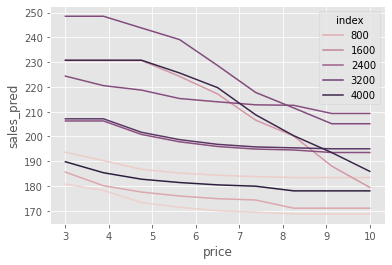

In [29]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=pred_test.query("index in @sample_ids"),
             x="price", y="sales_pred", hue="index");

일부 개체는 가격 인상에 매우 민감하다는 점이 흥미롭습니다. 어떤 경우에는 가격을 3에서 10으로 올리면 매출이 250에서 거의 200으로 떨어질 것으로 예상합니다. 반면에 가격에 매우 비탄력적인 단위도 있는데, 가격을 3에서 10으로 인상하면 판매량이 약 195에서 약 185로 감소할 것으로 예상합니다. 
 
가격 민감도의 이러한 차이를 확인하기 어렵기 때문에 모든 곡선을 동일한 지점(여기서는 평균 판매량)에서 시작하도록 하는 것이 좋습니다. 이렇게 하면 가격을 인상하면 매출이 급격히 감소하는 개체가 있는 반면 그렇지 않은 개체가 있다는 것을 더 쉽게 알 수 있습니다.

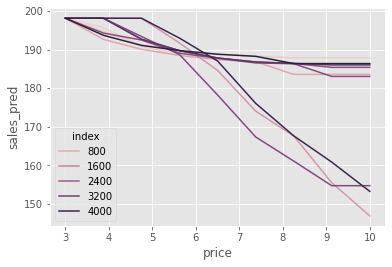

In [30]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"] + d["sales_pred"].mean())),
             x="price", y="sales_pred", hue="index");

### 더 많은 경제학적 지식이 필요할 수 있습니다!
 
![img](./data/img/debiased-ml/more-metrics.png)

비과학적인 이중 기계학습에 대한 이 섹션은 주의의 말씀과 함께 마무리하고자 합니다. 제가 이 접근법을 비과학적이라고 한 것은 괜히 그런 것이 아닙니다. 비선형적인 반사실 예측을 얻기 위한 일종의 해킹입니다. 그리고 해킹이기 때문에 잠재적인 단점에 대해 이야기할 가치가 있다고 생각합니다.
 
무엇보다도, 인과관계 추론에 단순하게 적용될 때 모든 기계학습 기법이 가지고 있는 문제, 즉 편향성이 있습니다. 최종 모델은 정규화된 기계학습 모델이기 때문에 이 정규화는 인과 관계 추정치를 0으로 편향시킬 수 있습니다. 
 
두 번째 문제는 선택한 기계학습 알고리즘과 관련이 있습니다. 여기서는 부스팅된 트리 모델을 선택합니다. 트리는 부드러운 예측에 능숙하지 않습니다. 결과적으로 예측 곡선에 불연속성이 발생할 수 있습니다. 위의 플롯에서 여기저기서 계단형식의 모양이 나타나는 것을 볼 수 있습니다. 또한 트리는 외삽에 능숙하지 않기 때문에 이 모델은 이전에 볼 수 없었던 이상한 가격 예측을 출력할 수 있습니다. 

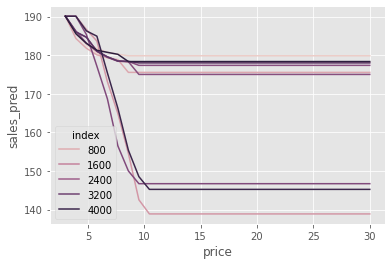

In [31]:
pred_test = (test
             .rename(columns={"price":"factual_price"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 30, 30))), on="jk")
             .drop(columns=["jk"]))

t_res_test = pred_test[T] - ensamble_pred(pred_test, models_t, X)

y_hat_test = ensamble_pred(pred_test, models_y, X)
pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test})) + y_hat_test

np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"] + d["sales_pred"].mean())),
             x="price", y="sales_pred", hue="index");

이 모든 것은 이 접근 방식이 최종 기계학습 모델에 크게 의존한다는 것을 의미합니다. 지나치게 정규화하면 인과 관계 추정치가 0으로 편향될 수 있습니다. 이 알고리즘이나 다른 기계학습 알고리즘을 사용하면 최종 반사실 예측에 모든 한계점이 적용됩니다. 그래도 이 접근 방식이 시도해 볼 가치가 있다고 생각되면 꼭 한번 시도해 보세요! 다만 여기서 설명한 단점을 잊지 마세요.

## 주요 아이디어들

이중/디베이즈/직교 ML은 불필요한 매개변수 추정을 위임하여 관심 있는 인과관계 매개변수에 집중할 수 있도록 하는 방법입니다. 먼저 2단계 직교화 절차를 사용합니다:
 
1. 공변량 X로부터 치료를 예측하기 위해 모델 $M_t(X)$를 맞추고 잔차값 $\tilde{t} = t - M_t(X)$를 얻습니다. 이를 디베이싱 모델이라고 부르는 이유는 잔차 $\tilde{t}$가 정의상 모델을 구성하는 데 사용된 특징과 직교하기 때문입니다.
 
2. 공변량 X로부터 결과를 예측하기 위해 모델 $M_y(X)$를 맞추고 잔차 $\tilde{y} = y - M_y(X)$를 얻습니다. 이를 노이즈 제거 모델이라고 부르는 이유는 잔차 $\tilde{y}$가 특징의 모든 분산이 설명된 결과의 버전으로 볼 수 있기 때문입니다.
 
측정되지 않은 교란 요소가 없다면 이러한 잔차를 구한 후 $\tilde{y}$를 $\tilde{t}$에 회귀시켜 ATE에 대한 선형 근사치를 구할 수 있습니다. 또한 공변량과 $\tilde{t}$를 상호 작용하여 CATE를 추정하거나 가중치 트릭을 사용하여 모든 일반 ML 모델을 최종 CATE 모델로 사용할 수 있습니다. 
 
![img](./data/img/debiased-ml/diagram.png) 
 
마지막으로, 저는 직교화 단계가 인과 학습을 촉진하는 일반적인 도구라고 주장했습니다. 이러한 정신에 따라 치료 및 결과 잔여값을 S-학습자 스타일의 ML 알고리즘에 공급하려고 시도했습니다. 이를 통해 시뮬레이션된 치료에서 사실과 반대되는 예측을 얻을 수 있었습니다. 실제로 직교 ML은 많은 인과관계 추론 애플리케이션에서 전처리 단계로 사용됩니다.
 
## 참고자료 

제가 여기에 쓴 글은 대부분 제 머릿속에서 나온 내용입니다. 저는 경험을 통해 배웠습니다. 즉, 훌륭한 과학이 흔히 거치는 학문적 검증을 통과하지 못했다는 뜻입니다. 대신 실제로 효과가 있는 것들에 대해 이야기하고 있지만, 왜 그런지 설명하는 데 너무 많은 시간을 할애하지 않는다는 점을 주목하세요. 일종의 길거리 과학이라고 할 수 있습니다. 그러나 저는 이 내용을 공개적으로 검토하기 위해 이 글을 올리는 것이므로 터무니없는 내용이 있으면 문제를 제기해 주시면 최선을 다해 해결해 드리겠습니다.
 
이 챕터를 작성하기 위해 저는 Chernozhukov 외(2016), *치료 및 인과 매개변수를 위한 이중/디베이즈 머신 러닝*, D. Foster 및 V. Syrgkanis(2019) *오르곤 통계 학습* 및 *econml* 라이브러리 문서 페이지에 의존했습니다. 직교 ML은 최근 많은 관심을 받고 있으므로 이 주제에 대한 다른 많은 참고 문헌이 있습니다. 몇 가지 예를 들자면, Nie와 Wager(초안, 2020)에서 R-loss에 대해 좋은 논의를 하고 있으며, Athey 등(2019)에서는 인과적 의사 결정 트리의 맥락에서 이에 대해 이야기하고 있으며, 이 주제를 더 발전시킨 Chernozhukov의 후속 논문도 많이 있습니다. 

이미지는 [Pedro Sant'Anna's slides](https://pedrohcgs.github.io/files/Callaway_SantAnna_2020_slides.pdf)에서 가져왔습니다.

 
## 기여

Causal Inference for the Brave and True는 인과추론, 통계학에 대한 오픈소스 자료입니다. 이 자료는 금전적으로나 모든 분들이 쉽게 접근하실 수 있도록 하는 것이 목표입니다. 또한, 이 책은 Python 기반의 무료 소프트웨어만 사용해요.
여러분들께서 이 자료가 가치 있다고 생각하시고, 금전적으로 지원을 원하신다면 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true)를 방문해주세요. 
만약 여러분이 금전적으로 기여하기가 쉽지 않으시다면, 오타 수정, 수정 제안, 이해하기 난해한 부분에 대한 피드백 제공 등을 통해 도움을 주실 수 있어요. 이 책의 Github 저장소 [이슈 페이지](https://github.com/CausalInferenceLab/Causal-Inference-with-Python/issues)를 방문해주세요. 마지막으로 이 자료가 여러분의 마음에 드셨다면 도움이 될 수 있는 다른 사람들과 공유해주시고, [한국어 번역 자료](https://github.com/CausalInferenceLab/Causal-Inference-with-Python/stargazers)와 [해당 번역본의 원서](https://github.com/matheusfacure/python-causality-handbook/stargazers)에 star 부탁드립니다!